In [3]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import re

import pandas as pd

#can comment this in and out to make interactable
#%matplotlib widget

# Use our custom style and colours
plt.style.use('shendrukGroupStyle')
import shendrukGroupFormat as ed

from matplotlib.animation import FFMpegWriter, PillowWriter, HTMLWriter
from matplotlib.collections import LineCollection

In [65]:
class polyAnalyser():
    def __init__(self, polyDataFileName, simLength, fluidDataFileName=None):
        self.polyDataFileName = polyDataFileName
        self.simLength = simLength
        self.fluidDataFileName = fluidDataFileName
        
        #extract the polymer data
        with open(self.polyDataFileName, 'r') as f:
            lines = f.readlines()
    
        #Skip header lines (first 82 lines, read empirally)
        data_lines = [line for line in lines[82:] if line.strip()]

        data = []
        current_t = 0.0
        timestep_increment = 0.1

        for line in data_lines:
            # Replace multiple spaces/tabs with single space and split
            cleaned_line = re.sub(r'\s+', ' ', line.strip())
            parts = cleaned_line.split(' ')
            
            # Check if this is a "timestep indexed" line (start of new block)
            if len(parts) >= 2 and parts[0] == 'timestep' and parts[1] == 'indexed':
                # Increment timestep for the next block
                current_t = round(current_t + timestep_increment, 10)
                continue  # Skip this header line
            
            # Process data lines (monomer index, x, y, z)
            if len(parts) >= 4:
                try:
                    data.append({
                        't': current_t,
                        'monomerIndex': int(parts[0]),
                        'x': float(parts[1]),
                        'y': float(parts[2]),
                        'z': float(parts[3]),
                    })
                except ValueError:
                    # Skip lines that can't be parsed as numbers
                    continue
    
        self.polyData=pd.DataFrame(data)
    

    def makeMovie(self):
        writer = FFMpegWriter(fps=10, bitrate=10000)
        output_file = 'particle_animation.mp4'

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')

        axesLim=30


        with writer.saving(fig, output_file, dpi=100):
            #currenlty not reading these values automatically, just reading from input.json myself
            for i in range(0, self.simLength+1):
                #calculate t value from i (dividing instead of multiplying as avoids floating point errors)
                t=i/10

                print('Currenlty processing frame at t = ', t)

                #fluid processing
                # x=data[data['t']==t]['qx']
                # y=data[data['t']==t]['qy']
                # z=data[data['t']==t]['qz']

                #monomerInfo
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex') #new line
                monoX=self.polyData[self.polyData['t']==t]['x']
                monoY=self.polyData[self.polyData['t']==t]['y']
                monoZ=self.polyData[self.polyData['t']==t]['z']

                #clear previous frame
                ax.clear()

                if len(monoX) > 1:
                    # Create rainbow colors for each segment
                    colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX) - 1))
                    
                    # Plot each segment between monomers with different color
                    for j in range(len(monoX) - 1):
                        ax.plot(monoX[j:j+2], monoY[j:j+2], monoZ[j:j+2],
                            color=colors[j], linewidth=3, alpha=0.8)
                    
                    # Add monomer points with matching colors
                    point_colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX)))
                    ax.scatter(monoX, monoY, monoZ, c=point_colors, s=40, alpha=1,
                            edgecolors='black', linewidth=0.5)

                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_xlim([0, axesLim])
                ax.set_ylim([0, axesLim])
                ax.set_zlim([0, axesLim])

                ax.set_title(f'Particle Positions at t = {t:.1f}')

                writer.grab_frame()
    

    #plots and returns data if you want to compare several simulations
    def plotAvgMonomerSpeeds(self):
        avgSpeedData=[]
        #loop between second and last-1 time frame 
        for i in range(2, self.simLength):
                #calculate t value from i (dividing instead of multiplying as avoids floating point errors)
                t=i/10
                tPrev=(i-1)/10

                dt=t-tPrev

                #previous monomerInfo
                monomerData = self.polyData[self.polyData['t'] == tPrev].sort_values('monomerIndex') #new line
                prevMonoX=self.polyData[self.polyData['t']==tPrev]['x']
                prevMonoY=self.polyData[self.polyData['t']==tPrev]['y']
                prevMonoZ=self.polyData[self.polyData['t']==tPrev]['z']

                #monomerInfo
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex') #new line
                monoX=self.polyData[self.polyData['t']==t]['x']
                monoY=self.polyData[self.polyData['t']==t]['y']
                monoZ=self.polyData[self.polyData['t']==t]['z']

              
                #print(monoX.values - prevMonoX.values, 'difference in X for 1 timestep  ')

                #calculate speeds
                speeds=np.sqrt((monoX.values - prevMonoX.values)**2 + (monoY.values - prevMonoY.values)**2 + (monoZ.values - prevMonoZ.values)**2)/dt
                #print(speeds, 'speeds')
                avgSpeed=np.mean(speeds)
                avgSpeedData.append(avgSpeed)
        
        plt.plot(range(self.simLength-2), avgSpeedData)
        plt.xlabel('Time step')
        plt.ylabel('Average monomer speed')
        plt.title('Average Monomer Speed vs Time')
        plt.show()

        return avgSpeedData

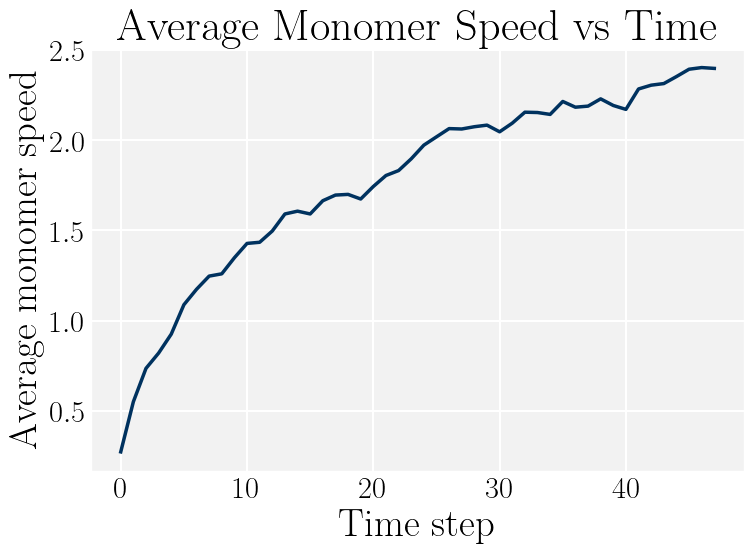

In [66]:
a=polyAnalyser('/Users/johnwhitfield/Desktop/readKnotTesting/exampleOutputs/comparingPopAndDens/3_1fluidpop/20251026-59383/20251026-59383-vmd.vtf', 50)
#a.makeMovie()
popSpeedData=a.plotAvgMonomerSpeeds()

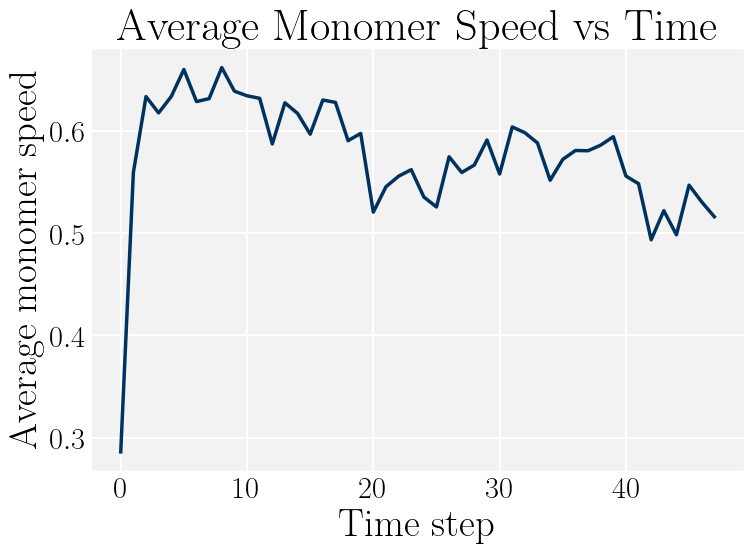

In [69]:
a=polyAnalyser('/Users/johnwhitfield/Desktop/readKnotTesting/exampleOutputs/comparingPopAndDens/3_1fluidDens/20251102-72366/20251102-72366-vmd.vtf', 50)
densSpeedData=a.plotAvgMonomerSpeeds()

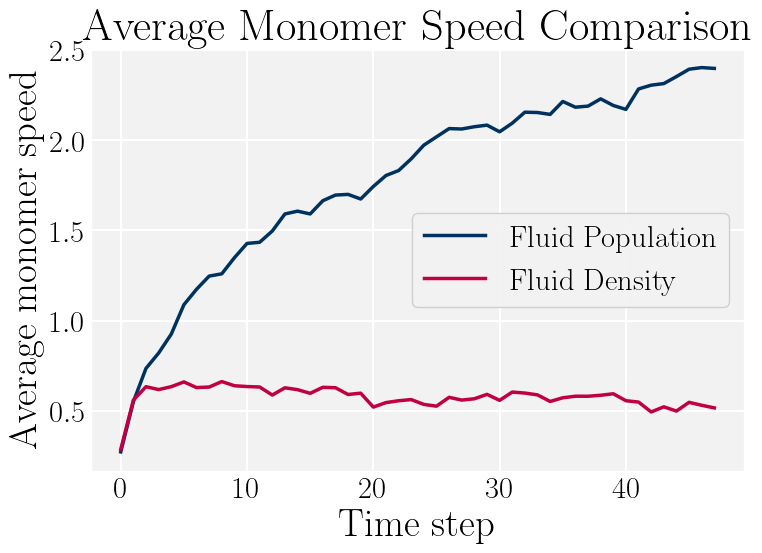

In [73]:
plt.plot(popSpeedData, label='Fluid Population')
plt.plot(densSpeedData, label='Fluid Density')
plt.xlabel('Time step')
plt.ylabel('Average monomer speed')
plt.title('Average Monomer Speed Comparison')
plt.legend()
plt.show()
